# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="../../images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Dataset & Modeling</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/advanced_tutorials/air_quality/3_training_dataset_and_modeling.ipynb)

<span style="font-width:bold; font-size: 1.4rem;">This notebook explains how to read from a feature group and create training dataset within the feature store</span>

## 🗒️ This notebook is divided into the following sections:

1. Fetch Feature Groups
2. Define Transformation functions
4. Create Feature Views
5. Create Training Dataset with training, validation and test splits

![part2](../../images/02_training-dataset.png) 

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
!pip install xgboost joblib matplotlib seaborn scikit-learn --q

In [ ]:
# !pip install 'git+https://git@github.com/logicalclocks/machine-learning-api@main#egg=hsml&subdirectory=python'
# !pip install 'git+https://git@github.com/logicalclocks/hopsworks-api@main#egg=hopsworks&subdirectory=python'

In [3]:
import os
import datetime
import time
import json
import pickle
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [4]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://35.231.25.90:443/p/119
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
air_quality_fg = fs.get_or_create_feature_group(
    name = 'air_quality',
    version = 1
)
weather_fg = fs.get_or_create_feature_group(
    name = 'weather',
    version = 1
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [6]:
query = air_quality_fg.select(['pm2_5']).join(weather_fg.select_except(['unix_time']), on=['city_name', 'date'])

`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.create_feature_view()` method.

You can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

In [8]:
# Uncomment this for Hopsworks 3.0
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=1,
    labels=['pm2_5'],
    query=query
)

Feature view created successfully, explore it at 
https://35.231.25.90:443/p/119/fs/67/fv/air_quality_fv/version/1


For now `Feature View` is saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view()`.

---

## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

To create training dataset you use `FeatureView.create_training_data()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- You can choose necessary format using **data_format** parameter.

- **start_time** and **end_time** in order to filter dataset in specific time range.

### <span style="color:#ff5f27;">🪝 Training Dataset Retrieval</span>

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hive (83.93s) 


In [10]:
X_train

,city_name,date,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_max,wind_gusts_max,wind_direction_dominant
0,Berlin,2013-01-01,7.5,5.5,1.8,1.8,0.0,7.0,21.4,38.9,220
1,Chicago,2013-01-01,-1.1,-6.8,0.0,0.0,0.0,0.0,18.8,34.2,333
2,Dallas,2013-01-01,9.3,4.3,1.3,1.3,0.0,4.0,18.0,35.3,349
3,Gdansk,2013-01-01,5.0,2.8,0.2,0.2,0.0,1.0,24.9,42.8,214
4,Kraków,2013-01-01,5.8,-2.6,0.0,0.0,0.0,0.0,10.7,21.2,197
...,...,...,...,...,...,...,...,...,...,...,...
156104,TACOMA - L STREET,2023-06-12,26.9,12.0,0.0,0.0,0.0,0.0,15.7,24.8,33
156105,Tacoma-S 36th St,2023-06-12,26.3,12.5,0.0,0.0,0.0,0.0,15.8,27.0,29
156106,Tallinn,2023-06-12,22.2,11.7,0.0,0.0,0.0,0.0,16.2,34.9,26
156107,Tukwila Allentown,2023-06-12,28.1,13.5,0.0,0.0,0.0,0.0,12.0,14.4,354


In [11]:
y_train

,pm2_5
0,39.0
1,10.4
2,13.4
3,15.0
4,153.0
...,...
156104,19.0
156105,19.0
156106,6.6
156107,20.9


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import make_column_transformer

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)


In [13]:
categorical_feature_ids = []
idx=0
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_feature_ids.append(idx)
    idx += 1

categorical_features = []
numeric_features = []
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_features.append(col)    

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
#         ("cat", categorical_transformer, categorical_feature_ids),
        ("cat", categorical_transformer, categorical_features),
      ]
)

### <span style='color:#ff5f27'> ⚖️ Model Validation

In [15]:
start_of_cell = time.time()
xgb_regressor = XGBRegressor()
xgb_regressor.feature_names = X_train.columns
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", xgb_regressor)]
)

clf.fit(X_train, y_train['pm2_5'].astype('int'))


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7ffb0ab26ee0>))]),
                                                  ['city_name', 'date'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsa...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [16]:

y_pred = clf.predict(X_test)

# calculate MSE using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# calculate RMSE using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

MSE: 79.03502664901063
RMSE: 8.890164601907584
R squared: 0.305251195376699
Took 3.9 sec.



In [17]:
df_ = pd.DataFrame({
    "y_true": y_test['pm2_5'].astype('int'),
    "y_pred": y_pred
})

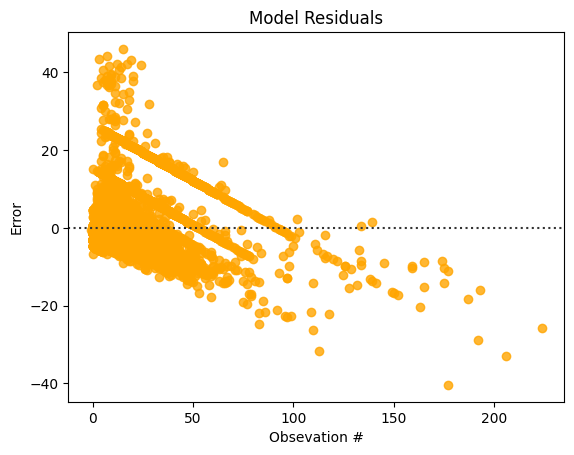

In [18]:
residplot = sns.residplot(data=df_, x="y_true", y="y_pred", color='orange')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()
fig = residplot.get_figure()
fig.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

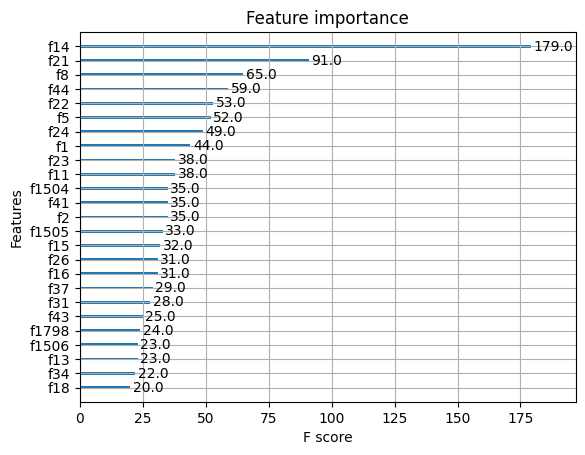

In [19]:
from xgboost import plot_importance

plot_importance(xgb_regressor, max_num_features=25)

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'city_name', 'type': 'object'},
   {'name': 'date', 'type': 'object'},
   {'name': 'temperature_max', 'type': 'float64'},
   {'name': 'temperature_min', 'type': 'float64'},
   {'name': 'precipitation_sum', 'type': 'float64'},
   {'name': 'rain_sum', 'type': 'float64'},
   {'name': 'snowfall_sum', 'type': 'float64'},
   {'name': 'precipitation_hours', 'type': 'float64'},
   {'name': 'wind_speed_max', 'type': 'float64'},
   {'name': 'wind_gusts_max', 'type': 'float64'},
   {'name': 'wind_direction_dominant', 'type': 'int64'}]},
 'output_schema': {'columnar_schema': [{'name': 'pm2_5', 'type': 'float64'}]}}

In [22]:
# The 'nyc_taxi_fares_model' directory will be saved to the model registry
model_dir="air_quality_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(clf, model_dir + '/xgboost_pipeline.pkl')

fig.savefig(model_dir + "/residplot.png") 

In [23]:
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2
    },
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor.")

aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://35.231.25.90:443/p/119/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

## Test Model

In [24]:
start_of_cell = time.time()

today = datetime.date.today()
date_threshold = today - datetime.timedelta(days=2)
str(date_threshold)

feature_view.init_batch_scoring(training_dataset_version=1)

batch_data = feature_view.get_batch_data(start_time=date_threshold)


end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

Finished: Reading data from Hopsworks, using Hive (23.89s) 
Took 27.86 sec.



In [25]:
batch_data

,city_name,date,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_max,wind_gusts_max,wind_direction_dominant
0,Berlin,2023-06-12,26.4,15.1,0.0,0.00,0.0,0.0,18.7,44.3,84
1,Chicago,2023-06-12,17.6,8.3,0.0,0.00,0.0,0.0,28.0,51.8,354
2,Dallas,2023-06-12,35.3,22.0,82.8,124.20,0.0,1.0,16.9,36.4,95
3,Gdansk,2023-06-12,20.2,13.3,0.0,0.00,0.0,0.0,15.2,35.3,53
4,Kraków,2023-06-12,19.6,11.7,0.0,0.00,0.0,0.0,15.9,45.0,69
5,LAKE FOREST PARK TOWNE CENTER,2023-06-12,27.5,12.6,0.0,0.00,0.0,0.0,10.4,14.8,7
6,MARYSVILLE - 7TH AVE (Marysville Junior High),2023-06-12,26.8,12.2,0.0,0.00,0.0,0.0,9.1,12.2,285
7,Madrid,2023-06-12,29.7,18.5,0.3,0.00,0.0,2.0,17.6,56.9,357
8,Napoli,2023-06-12,25.1,19.0,10.3,0.00,0.0,8.0,13.4,24.8,286
9,New York,2023-06-12,24.7,19.3,0.0,0.00,0.0,0.0,24.1,41.4,144


In [26]:
predictions = batch_data.copy()
predictions['prediction'] = clf.predict(batch_data)
predictions

,city_name,date,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_max,wind_gusts_max,wind_direction_dominant,prediction
0,Berlin,2023-06-12,26.4,15.1,0.0,0.00,0.0,0.0,18.7,44.3,84,13.211748
1,Chicago,2023-06-12,17.6,8.3,0.0,0.00,0.0,0.0,28.0,51.8,354,8.474370
2,Dallas,2023-06-12,35.3,22.0,82.8,124.20,0.0,1.0,16.9,36.4,95,8.286720
3,Gdansk,2023-06-12,20.2,13.3,0.0,0.00,0.0,0.0,15.2,35.3,53,12.825019
4,Kraków,2023-06-12,19.6,11.7,0.0,0.00,0.0,0.0,15.9,45.0,69,33.883720
5,LAKE FOREST PARK TOWNE CENTER,2023-06-12,27.5,12.6,0.0,0.00,0.0,0.0,10.4,14.8,7,7.287705
6,MARYSVILLE - 7TH AVE (Marysville Junior High),2023-06-12,26.8,12.2,0.0,0.00,0.0,0.0,9.1,12.2,285,8.015472
7,Madrid,2023-06-12,29.7,18.5,0.3,0.00,0.0,2.0,17.6,56.9,357,9.259607
8,Napoli,2023-06-12,25.1,19.0,10.3,0.00,0.0,8.0,13.4,24.8,286,16.999830
9,New York,2023-06-12,24.7,19.3,0.0,0.00,0.0,0.0,24.1,41.4,144,8.075011


---

---

### <span style="color:#ff5f27;">🥳 <b> Next Steps </b> </span>

Check out our other tutorials on ➡ https://github.com/logicalclocks/hopsworks-tutorials

Or documentation at ➡ https://docs.hopsworks.ai